In [59]:
import warnings
warnings.filterwarnings("ignore")
from ipypublish.scripts.ipynb_latex_setup import *
from IPython.display import display, Image, IFrame
import pymatgen as pym
import ipywidgets as widgets
import ipyvolume as ivol
from jsonextended import edict, plugins
plugins.load_builtin_plugins()
my_data = edict.LazyLoad('data/')

# Introduction

With the improvements in Jupyter Notebook, allowing for the synergy of browser-side javascript and client-side python coding, it is becoming possible to replicate the functionality of standalone atomic visualisation packages (such as [ovito](https://ovito.org/index.php/about)). The added benefits this approach brings is:

- Greater control and flexibility in the analysis and visualisation process 
- Fully autonomous replication of the analysis and visualisation
- Better documentation of the analysis and visualisation

The goal of this notebook is to show a method for:

1. reading/creating atomic configurations
2. visualising these in a Jupyter Notebook
3. Adding dynamic controls 
4. Overlaying electronic level data (probability/spin densities)
5. Distributing the output

# Creating Atomic Configurations

The [pymatgen](http://pymatgen.org/) package offers a means to create/manipulate atomic configurations with repeating boundary conditions. 

For this demonstration, we would like to select structures from a folder of cif (crystallographic information files). This is achieved by writing a *plugin* for [jsonextended](https://github.com/chrisjsewell/jsonextended), which is a package parsing file types into a json format and subsequent manipulation.

In [46]:
from pymatgen.io.cif import CifParser as cifparser
from collections import OrderedDict

class CIFPlugin(object):
    """ cif parser plugin for jsonextended
    """
    plugin_name = 'crytallographic_info_file'
    plugin_descript = 'read crytallographic information files, assumes single structure per file'
    file_regex = '*.cif'
        
    def read_file(self, file_obj, **kwargs):
        cif = cifparser.from_string(file_obj.read())
        dic = cif.as_dict()
        dic = dic[list(dic.keys())[0]]
        # remove underscores for key names
        new_dic = OrderedDict()
        for key in dic.keys():
            newkey = key[1:] if key.startswith('_') else key
            new_dic[newkey] = dic[key]
        new_dic['structure'] = cif.get_structures()[0]
        
        return new_dic        

In [3]:
plugins.load_plugin_classes([CIFPlugin],'parsers')
edict.pprint(my_data.cif_files, depth=1)

FeS_greigite.cif: {...}
FeS_mackinawite.cif: {...}
FeS_marcasite.cif: {...}
FeS_pyrite.cif: {...}
FeS_pyrrhotite_4C_c2c.cif: {...}
FeS_troilite.cif: {...}
Fe_bcc.cif: {...}
S_8alpha_fddd.cif: {...}
S_8beta_p21c.cif: {...}


For each cif, we can now access a pymatgen structure:

In [4]:
my_data.cif_files.FeS_mackinawite_cif.structure

Structure Summary
Lattice
    abc : 3.6735000000000002 3.6735000000000002 5.0327999999999999
 angles : 90.0 90.0 90.0
 volume : 67.91563420380001
      A : 3.6735000000000002 0.0 2.2493700083339009e-16
      B : -2.2493700083339009e-16 3.6735000000000002 2.2493700083339009e-16
      C : 0.0 0.0 5.0327999999999999
PeriodicSite: Fe (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Fe (1.8367, 1.8368, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: S (-0.0000, 1.8368, 1.3095) [0.0000, 0.5000, 0.2602]
PeriodicSite: S (1.8368, 0.0000, 3.7233) [0.5000, 0.0000, 0.7398]

# Preparation for visualisation

A visualisation requires the configuration to contain some additional information, 
including the atom shape (e.g. sphere radius) and texture (e.g. sphere color).

Therefore, it will be helpful to create a view agnostic (i.e. independendant of any specific graphics package) representation of all elements we wish to visualise. We do this by deconstructing the pymatgen structure and applying a mapping of atomic number to radius/color, using a pre-constructed csv table.

In [5]:
default_atom_map = pd.DataFrame(my_data.atom_data_csv.to_dict())
default_atom_map = default_atom_map.apply(pd.to_numeric,axis=0, errors='ignore')
default_atom_map.set_index('Number',inplace=True)
default_atom_map.index.name = ''
default_atom_map.head().round(2).drop(['MaxBnd','ARENeg'],axis=1)

,Blue,ElAffinity,ElNeg,Green,Ionization,Mass,Name,RBO,RCov,RVdW,Red,Symbol
,,,,,,,,,,,,
1,0.75,0.75,2.20,0.75,13.60,1.01,Hydrogen,0.31,0.31,1.10,0.75,H
2,1.00,0.00,0.00,1.00,24.59,4.00,Helium,0.28,0.28,1.40,0.85,He
3,1.00,0.62,0.98,0.50,5.39,6.94,Lithium,1.28,1.28,1.81,0.80,Li
4,0.00,0.00,1.57,1.00,9.32,9.01,Beryllium,0.96,0.96,1.53,0.76,Be
5,0.71,0.28,2.04,0.71,8.30,10.81,Boron,0.84,0.84,1.92,1.00,B


In [6]:
def struct_to_visual(struct,name,atom_map=None):
    if atom_map is None:
        atom_map = default_atom_map
    color = 'rgb({r},{g},{b})'
    a,b,c = [_ for _ in struct.lattice.matrix]
    centre = 0.5*(a+b+c)
    
    sdict = {}
    for anum, pos in zip(struct.atomic_numbers,struct.cart_coords):
        key = name+'_'+atom_map.loc[anum].Symbol
        if key not in sdict:
            sdict[key] = {}
            sdict[key]['type'] = 'scatter'
            sdict[key]['radius'] = atom_map.loc[anum].RCov    
            sdict[key]['transparency'] = 1.0
            sdict[key]['color'] = color.format(r=int(float(atom_map.loc[anum].Red)*255),
                                          g=int(float(atom_map.loc[anum].Green)*255),
                                          b=int(float(atom_map.loc[anum].Blue)*255))
            sdict[key]['label'] = atom_map.loc[anum].Symbol
            sdict[key]['centre'] = centre.copy()
            sdict[key]['cell_vectors'] = {}
            sdict[key]['cell_vectors']['a'] = a.copy()
            sdict[key]['cell_vectors']['b'] = b.copy()
            sdict[key]['cell_vectors']['c'] = c .copy()           
            sdict[key]['coords'] = []
            sdict[key]['visible'] = []
            
        sdict[key]['coords'].append(pos)
        sdict[key]['visible'].append(True)
    
    return sdict            

In [7]:
struct = my_data.cif_files.FeS_mackinawite_cif.structure
vstructs = struct_to_visual(struct,'mackinawite')
edict.pprint(vstructs,max_width=67,keycolor='blue')

mackinawite_Fe: 
  cell_vectors: 
    a: [ 3.67350000e+00 0.00000000e+00 2.24937001e-16]
    b: [ -2.24937001e-16 3.67350000e+00 2.24937001e-16]
    c: [ 0. 0. 5.0328]
  centre: [ 1.83675 1.83675 2.5164 ]
  color: rgb(224,102,51)
  coords: [[ 0. 0. 0.], [ 1.83675000e+00 1.83675000e+00 
                   2.24937001e-16]]
  label: Fe
  radius: 1.32
  transparency: 1.0
  type: scatter
  visible: [True, True]
mackinawite_S: 
  cell_vectors: 
    a: [ 3.67350000e+00 0.00000000e+00 2.24937001e-16]
    b: [ -2.24937001e-16 3.67350000e+00 2.24937001e-16]
    c: [ 0. 0. 5.0328]
  centre: [ 1.83675 1.83675 2.5164 ]
  color: rgb(178,178,0)
  coords: [[ -1.12468500e-16 1.83675000e+00 
                   1.30953456e+00], [ 1.83675 0. 3.72326544]]
  label: S
  radius: 1.05
  transparency: 1.0
  type: scatter
  visible: [True, True]


Since the representation is in a JSON format, it makes it very easy to extend to new types of elements. Note that we group atoms with the same visual representations, rather than specifying each atom separately. This is because it will be more efficient for the rendering process (see [here](http://www.ianww.com/blog/2012/11/04/optimizing-three-dot-js-performance-simulating-tens-of-thousands-of-independent-moving-objects/) for an explanation). Here we do this by atomic number, but equally it could be done by symmetry equivalence or another metric.

## Geometry Manipulation

We will also likely want to:

- create a supercell of the configuration 
- orientate the configuration in a convenient manner in the cartesian coordinate space
- slice into the configuration

In [8]:
def repeat_cell_scatter(vstruct,vector='a',rep=1,
                newcentre=True):
    assert vstruct['type'] == 'scatter'
    init_coords = vstruct['coords'][:]
    repv = vstruct['cell_vectors'][vector]
    vstruct['cell_vectors'][vector] = repv * (abs(rep)+1)
    
    if newcentre:
        vstruct['centre'] = 0.5*(vstruct['cell_vectors']['a']
                                +vstruct['cell_vectors']['b']
                                +vstruct['cell_vectors']['c'])
    
    for r in range(abs(rep)):
        v = -repv*(r+1) if rep<0 else repv*(r+1)
        vstruct['coords'] += [c+v for c in init_coords]
        vstruct['visible'] += [True for c in init_coords]

def recentre_scatter(vstruct,centre=(0.,0.,0.)):
    assert vstruct['type'] == 'scatter'
    centre=np.asarray(centre,dtype=float)
    tr = centre - vstruct['centre']
    vstruct['centre'] = centre
    vstruct['coords'] = [c+tr for c in vstruct['coords']]        

In [9]:
def _realign_vectors(vectors,v1,v2):
    """
    vectors : np.array((N,3))
    v1 : np.array((3,))
    v2 : np.array((3,))
    
    Examples
    --------
    >>> _realign_vectors(
    ...      [[1,0,0],[0,1,0],[0,0,1]],
    ...      [1,0,0],[0,1,0])
    ...
    array([[ 0.,  1.,  0.],
           [-1.,  0.,  0.],
           [ 0.,  0.,  1.]])
    
    """    
    # Normalize vector length
    i_v_norm = v1 / np.linalg.norm(v1)
    f_v_norm = v2 / np.linalg.norm(v2)
    # Get axis
    uvw = np.cross(i_v_norm, f_v_norm)
    # compute trig values - no need to go through arccos and back
    rcos = np.dot(i_v_norm, f_v_norm)
    rsin = np.linalg.norm(uvw)
    #normalize and unpack axis
    if not np.isclose(rsin, 0):
        uvw /= rsin
    u, v, w = uvw
    # Compute rotation matrix
    R = (
        rcos * np.eye(3) +
        rsin * np.array([
            [ 0,  w, -v],
            [-w,  0,  u],
            [ v, -u,  0]]) +
        (1.0 - rcos) * uvw[:,None] * uvw[None,:])
    return np.einsum('...jk,...k->...j',R.T,vectors)    

def align_scatter(vstruct,vector='a',direction=(1,0,0)):
    """align cell vector to a cartesian direction"""
    assert vstruct['type'] == 'scatter'
    direction=np.asarray(direction,dtype=float)
    v = vstruct['cell_vectors'][vector]
    coords = np.array(vstruct['coords'])
    new_coords = _realign_vectors(coords,v,direction)
    vstruct['coords'] = new_coords.tolist()
    new_cell = _realign_vectors([vstruct['cell_vectors']['a'],
                                 vstruct['cell_vectors']['b'],
                                 vstruct['cell_vectors']['c']],
                                 v,direction)
    vstruct['cell_vectors']['a'] = new_cell[0]
    vstruct['cell_vectors']['b'] = new_cell[1]
    vstruct['cell_vectors']['c'] = new_cell[2]
    

In [10]:
def _slice_mask(points, vector, 
               lbound=None,ubound=None, 
              origin=(0,0,0)):
    """compute mask for points within the lower and upper planes
    
    Properties
    ----------
    points : array((N,3))
    vector : array((3,))
        the vector normal to the slice planes
    ubound : None or float
        the fractional length (+/-) along the vector to create the upper slice plane
    lbound : None or float
        the fractional length (+/-) along the vector to create the lower slice plane
    origin : array((3,))
        the origin of the vector
        
    Examples
    --------
    >>> points = [[0,0,-5],[0,0,0],[0,0,5]]
    >>> slice_mask(points,[0,0,1],ubound=1)
    array([ True,  True, False], dtype=bool)
    
    >>> slice_mask(points,[0,0,1],lbound=1)
    array([False, False,  True], dtype=bool)
    
    >>> slice_mask(points,[0,0,1],lbound=-1,ubound=1)
    array([False,  True, False], dtype=bool)
    
    >>> slice_mask(points,[0,0,1],lbound=1,origin=[0,0,2])
    array([False, False,  True], dtype=bool)
    
    """
    mask = np.array([True for _ in points])

    if ubound is not None:
        cpoints = np.array(points) - np.array(origin) - np.array(vector) * ubound
        mask = mask & (np.einsum('j,ij->i',vector,cpoints) <=0)
    if lbound is not None:
        cpoints = np.array(points) - np.array(origin) - np.array(vector) * lbound
        mask = mask & (np.einsum('j,ij->i',vector,cpoints) >=0)

    return mask   

def cslice_scatter(vstruct,normal=(1,0,0),lbound=None,ubound=None,
          centre=None):
    assert vstruct['type'] == 'scatter'
    normal=np.asarray(normal,dtype=float)
    vstruct['visible'] = _slice_mask(vstruct['coords'],
                                   normal,lbound,ubound,
                    vstruct['centre'] if centre is None else centre).tolist()

We can group these operations into a class, which is extensible to more geometric operation and element types.

In [11]:
class GeometryManipulation(object):
    
    _manip_dict = {
        'scatter':{'repeat_cell':repeat_cell_scatter,
                   'recentre':recentre_scatter,
                   'align':align_scatter,
                   'cslice':cslice_scatter}
    }
    def _apply_manip(self,vstructs,manip,*args,**kwargs):
        for vstruct in vstructs.values():
            vtype = vstruct['type']
            if vtype not in self._manip_dict:
                warning.warn('skipping type {} as not available'.format(vtype))
                continue
            func = self._manip_dict[vtype][manip]
            func(vstruct,*args,**kwargs)
    
    def repeat_cell(self,vstructs,vector='a',rep=1,
                    newcentre=True):
        """repeat the cell <rep> times in the <vector> direction
        if newcentre, apply a new centre position, 
        at the midpoint of the cell vectors
        """
        self._apply_manip(vstructs,'repeat_cell',
                    vector,rep,newcentre)            
    def recentre(self,vstructs,centre=(0.,0.,0.)):   
        """translate the element positions to the new centre
        """
        self._apply_manip(vstructs,'recentre',centre)
    def align(self,vstructs,vector='a',direction=(1,0,0)):
        """ align a cell vector to a cartesian vector
        """
        self._apply_manip(vstructs,'align',
                    vector,direction)
    def cslice(self,vstructs,normal=(1,0,0),
               lbound=None,ubound=None,centre=None):
        """ set elements visibility, outside the slice planes,
        to be False
        """
        self._apply_manip(vstructs,'cslice',
                    normal,lbound,ubound,centre)


In [12]:
vstructs = struct_to_visual(struct,'mackinawite')

geomanip = GeometryManipulation()
geomanip.align(vstructs,'b')
geomanip.repeat_cell(vstructs,'a',2)
geomanip.recentre(vstructs)
geomanip.cslice(vstructs,(0,0,1),ubound=1.)

edict.pprint(vstructs,max_width=67,keycolor='blue')

mackinawite_Fe: 
  cell_vectors: 
    a: [ -6.74811003e-16 -1.10205000e+01 -1.47911420e-31]
    b: [ 3.67350000e+00 -1.37734189e-32 -4.93038066e-32]
    c: [ 3.08170121e-16 -3.08170121e-16 5.03280000e+00]
  centre: [ 0. 0. 0.]
  color: rgb(224,102,51)
  coords: [[-1.83675 5.51025 -2.5164 ], [ 0. 3.6735 
                   -2.5164], [-1.83675 1.83675 -2.5164 ], [ 
                   -2.22044605e-16 0.00000000e+00 -2.51640000e+00], 
                   [-1.83675 -1.83675 -2.5164 ], [ -4.44089210e-16 
                   -3.67350000e+00 -2.51640000e+00]]
  label: Fe
  radius: 1.32
  transparency: 1.0
  type: scatter
  visible: [True, True, True, True, True, True]
mackinawite_S: 
  cell_vectors: 
    a: [ -6.74811003e-16 -1.10205000e+01 -1.47911420e-31]
    b: [ 3.67350000e+00 -1.37734189e-32 -4.93038066e-32]
    c: [ 3.08170121e-16 -3.08170121e-16 5.03280000e+00]
  centre: [ 0. 0. 0.]
  color: rgb(178,178,0)
  coords: [[ 2.22044605e-16 5.51025000e+00 
                   -1.20686544e+00], [-

# Visualising in the Jupyter Notebook

To create 3D renderings of the configuration, we will use [ipyvolume](http://ipyvolume.readthedocs.io) and its implementation of the model/view pattern.

In [42]:
import ipyvolume.pylab as p3
def create_ivol(vstructs,
                width=500,height=400):
    p3.clear()
    fig = p3.figure(width=width,height=height,controls=True)
    fig.screen_capture_enabled = True
    
    for vstruct in vstructs.values():
        if vstruct['type'] == 'scatter':    
            coords = np.array(vstruct['coords'])[vstruct['visible']]
            x, y, z = coords.T
            s = p3.scatter(x,y,z,marker='sphere',size=6,color=vstruct['color'])        
            vstruct['ivol'] = s
    
    # split up controls
    figbox, fullscreen = p3.gcc().children
    
    return fig, {'view':[fullscreen]}

vstructs = struct_to_visual(struct,'mackinawite')
geomanip = GeometryManipulation()
geomanip.align(vstructs,'b')
geomanip.repeat_cell(vstructs,'a',3)
geomanip.repeat_cell(vstructs,'b',3)
geomanip.repeat_cell(vstructs,'c',3)
geomanip.recentre(vstructs,(0.0, 0.0, 0.0))
geomanip.cslice(vstructs,(0,0,1),ubound=-4)

fig, controls1 = create_ivol(vstructs)
#fig.anglex = np.radians(90) # has to be used after instantiation
gui = widgets.VBox([fig,controls1['view'][0]])
gui

A Jupyter Widget

The rendering can also be captured as a screenshot or saved as an image/html. We shall discuss in [a later section](#Analysis-Distribution) how this can be utilised for to distribute the analysis.

In [16]:
image = p3.screenshot(width=500, height=500)
ivol.embed.embed_html('data/ivol_example1.html',
                     [gui])

A Jupyter Widget

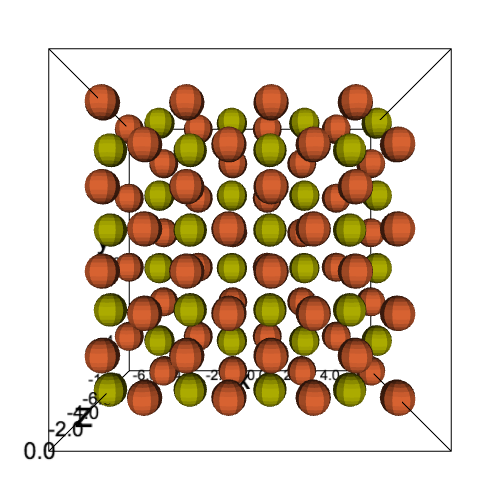

In [17]:
display(image,metadata={'ipub':{'embed_html':{
    "filepath":'data/ivol_example1.html'}}})

# Adding Dynamic Controls

[ipyvolume](http://ipyvolume.readthedocs.io) utilises the [ipywidgets](http://ipywidgets.readthedocs.io) framework and thus it is relatively trivial to set up dynamic controls.

In [18]:
def create_ivol_control(vstruct,vparam,ctype,cparam='value',**ckwargs):
    """"""
    assert 'ivol' in vstruct
    ctrl = getattr(widgets,ctype)(**ckwargs)
    widgets.jslink((vstruct['ivol'], vparam), (ctrl, cparam))
    
    return ctrl

cntrl = create_ivol_control(vstructs['mackinawite_Fe'],'size',
                    'FloatSlider','value',min=0,max=10,
                    description='Fe Size')
cntrl

A Jupyter Widget

We can bundle these in with the original container to create a bespoke GUI.

In [19]:
def add_controls(fig, ctrl_layout,
                top=False):
    """"""
    if not ctrl_layout:
        return fig
    if isinstance(ctrl_layout,list):
        layout = []
        for cntrl in ctrl_layout:
            if isinstance(cntrl,list):
                cntrl = widgets.HBox(cntrl)
            layout.append(cntrl)
        options = widgets.VBox(layout)
    else:
        tabs = OrderedDict()
        for name, cntrls in ctrl_layout.items():
            layout = []
            for cntrl in cntrls:
                if isinstance(cntrl,list):
                    cntrl = widgets.HBox(cntrl)
                layout.append(cntrl)
            tabs[name] = widgets.VBox(cntrls)
        options = widgets.Tab(children=tuple(tabs.values()))
        for i, name in enumerate(tabs):
            options.set_title(i, name)
        
    if top:
        return widgets.VBox([options,fig])
    else:
        return widgets.VBox([fig,options])

In [43]:
cntrls = controls1
for name, vstruct in vstructs.items():
    cntrl1 = create_ivol_control(vstruct,'size',
                        'FloatSlider','value',min=0,max=10,
                        description='Size')
    cntrl2 = create_ivol_control(vstruct,'color',
                        'ColorPicker','value',
                        description='Color')
    cntrls[name.replace('_',' ')] = [cntrl1,cntrl2]
    
new_gui = add_controls(fig,cntrls,top=True) 
new_gui

A Jupyter Widget

In [44]:
image2 = p3.screenshot(width=500, height=500)
ivol.embed.embed_html('data/ivol_example2.html',
                     [new_gui])

A Jupyter Widget

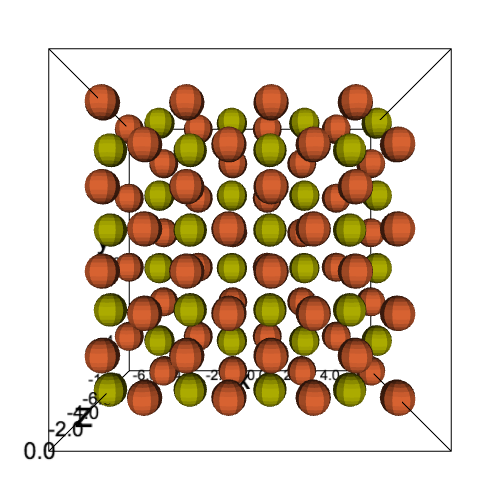

In [51]:
display(image2,metadata={'ipub':{'embed_html':{
    "filepath":'data/ivol_example2.html',
     "height":0.45}}})

# Overlaying electronic level data

*Ab initio* quantum simulation packages can compute electronic/spin densities (to accompany the nuclei positions) in the form of a discretized 3D cube. These can be overlayed onto the nuclei, by [volume rendering](https://en.wikipedia.org/wiki/Volume_rendering) or [isosurface](https://en.wikipedia.org/wiki/Isosurface) methods. 

## Data Parsing

Taking the [CRYSTAL](http://www.crystal.unito.it/index.php) program as an example, output from the electronic density is principally output into two files; one that contains the lattice vectors and nuclei coordinates and one that contains a data cube of the electronic density, with axis relating to the cell vectors. We can write parser plugins for both these files:

In [23]:
class ECH3OutPlugin(object):
    """ parser plugin for jsonextended
    """
    plugin_name = 'crystal_ech3_out'
    plugin_descript = 'read CRYSTAL14 charge density out data'
    file_regex = '*ech3.out'
        
    def read_file(self, file_obj, **kwargs):
        """
 DIRECT LATTICE VECTOR COMPONENTS (ANGSTROM)
         0.00000    2.71000    2.71000
         2.71000    0.00000    2.71000
         2.71000    2.71000    0.00000
...
 *******************************************************************************
   ATOM N.AT.  SHELL    X(A)      Y(A)      Z(A)      EXAD       N.ELECT.
 *******************************************************************************
    1   14 SI    4     0.678     0.678     0.678   1.233E-01      14.000
    2   14 SI    4    -0.677    -0.678    -0.677   1.233E-01      14.000
 *******************************************************************************        
        """
        sites, coords = [], []
        line = file_obj.readline()
        while line:
            if line.strip().startswith('DIRECT LATTICE VECTOR COMPONENTS'):
                a = np.array(file_obj.readline().strip().split(),dtype=float)
                b = np.array(file_obj.readline().strip().split(),dtype=float)
                c = np.array(file_obj.readline().strip().split(),dtype=float)
            if line.strip().startswith('ATOM N.AT.'):
                line = file_obj.readline()
                line = file_obj.readline()
                while not line.strip().startswith('***'):
                    atom = line.strip().split()
                    sites.append(int(atom[1]))
                    coords.append(np.array(atom[4:7],dtype=float))
                    line = file_obj.readline()                
            line = file_obj.readline()
            
        lattice = pym.Lattice([a,b,c])
        struct = pym.Structure(lattice,sites,coords,
                               to_unit_cell=True,
                               coords_are_cartesian=True)
        return {'structure':struct}

In [24]:
class ECH3CubePlugin(object):
    """ parser plugin for jsonextended
    """
    plugin_name = 'crystal_ech3_cube'
    plugin_descript = 'read CRYSTAL14 charge density cube data'
    file_regex = '*ech3_dat.prop3d'
        
    def read_file(self, f, **kwargs):
        dic = {}

        na,nb,nc = [int(i) for i in f.readline().strip().split()]
        dic['na'],dic['nb'],dic['nc'] = na,nb,nc
        dic['o_vec'] = [float(i) for i in f.readline().strip().split()]
        dic['da_vec'] = np.array([float(i) for i in f.readline().strip().split()])
        dic['db_vec'] = np.array([float(i) for i in f.readline().strip().split()])
        dic['dc_vec'] = np.array([float(i) for i in f.readline().strip().split()]) 
        name = f.readline().strip()
        assert name == 'Charge density'
        charge_density = []
        line = f.readline().strip().split()
        while line:
            if line[0] == 'Spin':
                break
            charge_density += [float(s) for s in line]
            line = f.readline().strip().split()
        dense = np.array(charge_density).reshape((na,nb,nc))
        dic['charge_density'] = dense
        spin_density = []
        line = f.readline().strip().split()
        while line:
            spin_density += [float(s) for s in line]
            line = f.readline().strip().split()
        if spin_density:
            dense = np.array(spin_density).reshape((na,nb,nc))
            dic['spin_density'] = dense

        return dic

In [50]:
plugins.load_plugin_classes([ECH3OutPlugin,ECH3CubePlugin],'parsers')
edict.pprint(my_data.crystal,keycolor='blue')

ech3.out: 
  structure: Full Formula (Si2) Reduced Formula: Si abc   :   3.832519 
                      3.832519   3.832519 angles:  60.000000  60.000000 
                      60.000000 Sites (2)   #  SP           a         b 
                      c ---  ----  --------  --------  --------   0  Si 
                      0.125092  0.125092  0.125092   1  Si    0.874908  0.875277 
                      0.874908
ech3_dat.prop3d: 
  charge_density: np.array((100, 100, 100), min=2.68E-03, max=5.36E+02)
  da_vec: [ 0. 0.051729 0.051729]
  db_vec: [ 0.051729 0. 0.051729]
  dc_vec: [ 0.051729 0.051729 0. ]
  na:    100
  nb:    100
  nc:    100
  o_vec: [0.0, 0.0, 0.0]


## Visualisation Preparation

We then, follow the same process as for atoms; converting to a common structure and adding geometric manipulation functions for this data type.

In [52]:
def dcube_to_visual(cube,struct,name):
    sdict = {name:{}}
    a,b,c = [_ for _ in struct.lattice.matrix]
    centre = 0.5*(a+b+c)

    sdict[name]['type'] = 'volume'
    sdict[name]['centre'] = centre.copy()
    sdict[name]['dcube'] = cube.copy()
    sdict[name]['cell_vectors'] = {}
    sdict[name]['cell_vectors']['a'] = a.copy()
    sdict[name]['cell_vectors']['b'] = b.copy()
    sdict[name]['cell_vectors']['c'] = c.copy() 
    sdict[name]['slices'] = []
    return sdict

nuclei = struct_to_visual(my_data.crystal.ech3_out['structure'],'Silicon')
electrons = dcube_to_visual(my_data.crystal.ech3_dat_prop3d['charge_density'],
                            my_data.crystal.ech3_out['structure'],
                            'Silicon Charge')
dstructs = edict.merge([nuclei,electrons])
edict.pprint(dstructs,keycolor="blue")

Silicon Charge: 
  cell_vectors: 
    a: [ 0. 2.71 2.71]
    b: [ 2.71 0. 2.71]
    c: [ 2.71 2.71 0. ]
  centre: [ 2.71 2.71 2.71]
  dcube: np.array((100, 100, 100), min=2.68E-03, max=5.36E+02)
  slices: []
  type: volume
Silicon_Si: 
  cell_vectors: 
    a: [ 0. 2.71 2.71]
    b: [ 2.71 0. 2.71]
    c: [ 2.71 2.71 0. ]
  centre: [ 2.71 2.71 2.71]
  color: rgb(127,153,153)
  coords: [[ 0.678 0.678 0.678], [ 4.743 4.742 4.743]]
  label: Si
  radius: 1.11
  transparency: 1.0
  type: scatter
  visible: [True, True]


In [29]:
def repeat_cell_volume(vstruct,vector='a',rep=1,
                newcentre=True):    
    assert vstruct['type'] == 'volume'
    reps = OrderedDict([('a',1),('b',1),('c',1)])
    reps[vector] += abs(rep)
    vstruct['dcube'] = np.tile(vstruct['dcube'],
                               list(reps.values()))
    
    repv = vstruct['cell_vectors'][vector]
    vstruct['cell_vectors'][vector] = repv * (abs(rep)+1)
    
    if newcentre:
        vstruct['centre'] = 0.5*(vstruct['cell_vectors']['a']
                                +vstruct['cell_vectors']['b']
                                +vstruct['cell_vectors']['c'])

def recentre_volume(vstruct,centre=(0.,0.,0.)):
    assert vstruct['type'] == 'volume'
    vstruct['centre'] = np.asarray(centre,dtype=float)   

def align_volume(vstruct,vector='a',direction=(1,0,0)):
    """align cell vector to a cartesian direction"""
    assert vstruct['type'] == 'volume'
    direction=np.asarray(direction,dtype=float)
    v = vstruct['cell_vectors'][vector]
    new_cell = _realign_vectors([vstruct['cell_vectors']['a'],
                                 vstruct['cell_vectors']['b'],
                                 vstruct['cell_vectors']['c']],
                                 v,direction)
    vstruct['cell_vectors']['a'] = new_cell[0]
    vstruct['cell_vectors']['b'] = new_cell[1]
    vstruct['cell_vectors']['c'] = new_cell[2]

def cslice_volume(vstruct,normal=(1,0,0),lbound=None,ubound=None,
          centre=None):
    assert vstruct['type'] == 'volume'
    normal=np.asarray(normal,dtype=float)
    vstruct['slices'].append((
        normal,lbound,ubound,centre)) 

class NewGeometryManipulation(GeometryManipulation):
    _manip_dict = {
        'scatter':{'repeat_cell':repeat_cell_scatter,
                   'recentre':recentre_scatter,
                   'align':align_scatter,
                   'cslice':cslice_scatter},
        'volume':{'repeat_cell':repeat_cell_volume,
                   'recentre':recentre_volume,
                   'align':align_volume,
                   'cslice':cslice_volume}
    }
    def align(self,*args,**kwargs):
        raise NotImplementedError(
            'rotating cell vectors currently not working for volumes')

In [30]:
nuclei = struct_to_visual(my_data.crystal.ech3_out['structure'],'Silicon')
electrons = dcube_to_visual(my_data.crystal.ech3_dat_prop3d['charge_density'],
                            my_data.crystal.ech3_out['structure'],
                            'Silicon Charge')
dstructs = edict.merge([nuclei,electrons])
geomanip = NewGeometryManipulation()
#geomanip.align(dstructs,'b')
geomanip.repeat_cell(dstructs,'a',3)
geomanip.repeat_cell(dstructs,'b',3)
geomanip.repeat_cell(dstructs,'c',3)
geomanip.recentre(dstructs,(0.0, 0.0, 0.0))
geomanip.cslice(dstructs,(0,0,1),ubound=-4)
edict.pprint(dstructs['Silicon Charge'])

cell_vectors: 
  a: [ 0. 10.84 10.84]
  b: [ 10.84 0. 10.84]
  c: [ 10.84 10.84 0. ]
centre: [ 0. 0. 0.]
dcube:  np.array((400, 400, 400), min=2.68E-03, max=5.36E+02)
slices: [([ 0. 0. 1.], None, -4, None)]
type:   volume


## Visualisation

For ipyvolume, at present, the volume data must a cube of equal dimensions. 
Therefore, we use the cell vectors to transform the data cube into cartesian coordinates,
such that voxels (cube sections) outside of the cell volume are set as np.nan values.
We also resize the discretisation of the cube to an appropriate size for the renderer to handle. 

In [31]:
from scipy.spatial import Delaunay
from scipy.interpolate import interpn

def cartesian_basis3d(A,v1,v2,v3,
                      centre=(0.,0.,0.),
                     max_dim=None,
                     interp='nearest'):
    """convert 3d array in basis v1,v2,v3 to cartesian basis

    Properties
    ----------
    A : array((N,M,L))
        values in original basis 
    v1 : array((3,))
    v2 : array((3,))
    v3 : array((3,))
    centre : array((3,))
    max_dim : int
        maximum axis dimension of returned cube
        if None will use the maximum dimension of A
    interp : str
        interpolation mode; 'nearest' or 'linear'

    Returns
    -------
    B : array((P,Q,R))
        where P,Q,R <= longest_side
    min_bounds : array((3,))
        xmin,ymin,zmin
    max_bounds : array((3,))
        xmax,ymax,zmax

    """   
    
    if max_dim is not None:
        longest_side = min(max(A.shape),max_dim)
    else:
        longest_side = max(A.shape)

    # assumed
    origin = [0,0,0]

    # convert to numpy arrays
    origin = np.asarray(origin)
    v1 = np.asarray(v1)
    v2 = np.asarray(v2)
    v3 = np.asarray(v3)

    # pre-compute basis transformation matrix
    M_inv = np.linalg.inv(np.transpose([v1,v2,v3]))

    # only works right if transposed before and after?
    A = np.array(A).T
    # add bounding layers for interpolation
    A = np.concatenate((np.array(A[0],ndmin=3),A,np.array(A[-1],ndmin=3)),axis=0)
    start = np.transpose(np.array(A[:,:,0],ndmin=3),axes=[1,2,0])
    end = np.transpose(np.array(A[:,:,-1],ndmin=3),axes=[1,2,0])
    A = np.concatenate((start,A,end),axis=2)
    start = np.transpose(np.array(A[:,0,:],ndmin=3),axes=[1,0,2])
    end = np.transpose(np.array(A[:,-1,:],ndmin=3),axes=[1,0,2])
    A = np.concatenate((start,A,end),axis=1)

    # create axes
    axes=[]
    for i,v in enumerate([v1,v2,v3]):
        step = 1./(A.shape[i]-2)
        ax = np.linspace(0,1+step,A.shape[i]) - step/2.
        axes.append(ax)

    # get bounding box and compute it volume and extents
    bbox_pts=np.asarray([origin,v1,v2,v3,v1+v2,v1+v3,v1+v2+v3,v2+v3])
    hull = Delaunay(bbox_pts)

    bbox_x, bbox_y, bbox_z = bbox_pts.T
    new_bounds = bbox_x.min(),bbox_x.max(),bbox_y.min(),bbox_y.max(),bbox_z.min(),bbox_z.max() #l,r,bottom,top
    min_bound, max_bound = min(bbox_x.min(),bbox_y.min(),bbox_z.min()), max(bbox_x.max(),bbox_y.max(),bbox_z.min())

    # compute new array size
    x_length = abs(new_bounds[0]-new_bounds[1])
    y_length = abs(new_bounds[2]-new_bounds[3])
    z_length = abs(new_bounds[4]-new_bounds[5])
    if x_length == max([x_length,y_length,z_length]):
        xlen = longest_side
        ylen = int(longest_side*y_length/float(x_length))
        zlen = int(longest_side*z_length/float(x_length))
    elif y_length == max([x_length,y_length,z_length]):
        ylen = longest_side
        xlen = int(longest_side*x_length/float(y_length))
        zlen = int(longest_side*z_length/float(y_length))
    else:
        zlen = longest_side
        xlen = int(longest_side*x_length/float(z_length))
        ylen = int(longest_side*y_length/float(z_length))

    # compute new array values
    new_array = np.full((xlen,ylen,zlen),np.nan)
    xidx, yidx, zidx = np.meshgrid(range(new_array.shape[0]),range(new_array.shape[1]),range(new_array.shape[2]))
    xidx=xidx.flatten()
    yidx=yidx.flatten()
    zidx=zidx.flatten()
    xyzidx = np.concatenate((np.array(xidx,ndmin=2).T,np.array(yidx,ndmin=2).T,np.array(zidx,ndmin=2).T),axis=1)
    xyz = min_bound+(xyzidx.astype(float)*abs(min_bound-max_bound)/longest_side)
    # find if point is inside bounding box 
    inside_mask = hull.find_simplex(xyz)>=0
    uvw = np.einsum('...jk,...k->...j',M_inv,xyz[inside_mask])
    new_array[xyzidx[inside_mask][:,0],xyzidx[inside_mask][:,1],xyzidx[inside_mask][:,2]] = interpn(axes,A,uvw,bounds_error=True,method=interp)
    new_array = new_array.T  
    
    xmin,xmax,ymin,ymax,zmin,zmax = new_bounds
    return (new_array, 
            np.array((xmin,ymin,zmin)) - 0.5*(v1+v2+v3) + np.array(centre), 
            np.array((xmax,ymax,zmax)) - 0.5*(v1+v2+v3) + np.array(centre))


Additionally, for ipyvolume (in its current state), there can only be one volume rendering per scene and it is assumed that the volumes bottom left corner is at (0,0,0).

In [32]:
nuclei = struct_to_visual(my_data.crystal.ech3_out['structure'],'Silicon')
electrons = dcube_to_visual(my_data.crystal.ech3_dat_prop3d['charge_density'],
                            my_data.crystal.ech3_out['structure'],
                            'Silicon Charge')
dstructs = edict.merge([nuclei,electrons])
geomanip = NewGeometryManipulation()
#geomanip.align(dstructs,'b')
geomanip.repeat_cell(dstructs,'a',3)
geomanip.repeat_cell(dstructs,'b',3)
geomanip.repeat_cell(dstructs,'c',3)
geomanip.recentre(dstructs,(0.0, 0.0, 0.0))
geomanip.cslice(dstructs,(0,1,1),lbound=-2,ubound=0)

edict.pprint(dstructs['Silicon Charge'])

cell_vectors: 
  a: [ 0. 10.84 10.84]
  b: [ 10.84 0. 10.84]
  c: [ 10.84 10.84 0. ]
centre: [ 0. 0. 0.]
dcube:  np.array((400, 400, 400), min=2.68E-03, max=5.36E+02)
slices: [([ 0. 1. 1.], -2, 0, None)]
type:   volume


In [33]:
def slice_cube(cube,minb,maxb,
               normal,lbound=None,ubound=None,
               origin=(0.,0.,0.)):
    tr = (2,0,1)
    cubet = cube.transpose(tr)
    xdim,ydim,zdim = cubet.shape

    x,y,z = np.meshgrid(np.arange(0,xdim),np.arange(0,ydim),np.arange(0,zdim))
    indices = np.array((x.flatten(),y.flatten(),z.flatten())).T
    coords = np.divide(indices,np.array((xdim-1,ydim-1,zdim-1)))
    coords = coords * (np.abs(maxb-minb)) + minb

    mask = _slice_mask(coords,normal,lbound,ubound,origin)
    mask = mask.reshape(cubet.shape)
    cubet[~mask] = np.nan
    return cubet.transpose(tr)

def create_ivol2(vstructs,
                width=500,height=400,
                max_dim=100,
                controls=True,
                **volargs):
    
    # ensure there is only one volume
    types = edict.filter_keys(vstructs,['type'])
    voltypes = edict.filter_values(types,['volume']) 
    assert len(voltypes)<=1, "there can only be one volume rendering per scene"

    p3.clear()
    fig = p3.figure(width=width,height=height,controls=controls)
    fig.screen_capture_enabled = True

    if voltypes:
        volstruct = vstructs[list(voltypes.keys())[0]]
        a = volstruct['cell_vectors']['a']
        b = volstruct['cell_vectors']['b']
        c = volstruct['cell_vectors']['c']
        
        # convert dcube to cartesian
        out = cartesian_basis3d(volstruct['dcube'],a,b,c,
                                volstruct['centre'],
                                max_dim=max_dim)
        new_density, minb, maxb = out
        for norm,lbound,ubound,centre in volstruct['slices']:
            new_density = slice_cube(
                new_density,minb,maxb,
                norm,lbound,ubound,
                volstruct['centre'] if centre is None else centre)

        vol = p3.volshow(new_density,**volargs,)
        volstruct['ivol'] = vol
        
        # appropriately scale axis
        xmin,ymin,zmin = minb
        xmax,ymax,zmax = maxb
        p3.xlim(xmin,xmax)
        p3.ylim(ymin,ymax)
        p3.zlim(zmin,zmax)    
    
    for vstruct in vstructs.values():
        if vstruct['type'] == 'scatter':    
            coords = np.array(vstruct['coords'])[vstruct['visible']]
            x, y, z = coords.T
            s = p3.scatter(x,y,z,marker='sphere',size=3,color=vstruct['color'])        
            vstruct['ivol'] = s
    
    # split up controls
    if voltypes:
        (level_ctrls, figbox, fullscreen, 
         extractrl1,extractrl2) = p3.gcc().children
        controls = OrderedDict([('transfer function',[level_ctrls]),
                    ('lighting',[extractrl1,extractrl2]),
                    ('view',[fullscreen])])
    else:
        figbox, fullscreen = p3.gcc().children    
        controls = {'view':[fullscreen]}
    
    return fig, controls

In [34]:
fig, controls = create_ivol2(dstructs,data_min=1.6,data_max=2,
                            level=[.5, .25, .1],opacity=[.2,.15,.05])
cntrl = create_ivol_control(
    dstructs['Silicon_Si'],'size',
    'FloatSlider','value',
     min=0, max=10,
     description='Size')
controls['Nucleii'] = [cntrl]
volgui = add_controls(fig,controls)
volgui

A Jupyter Widget

In [35]:
image3 = p3.screenshot(width=500, height=500)
ivol.embed.embed_html('data/ivol_example3.html',
                     [volgui])

A Jupyter Widget

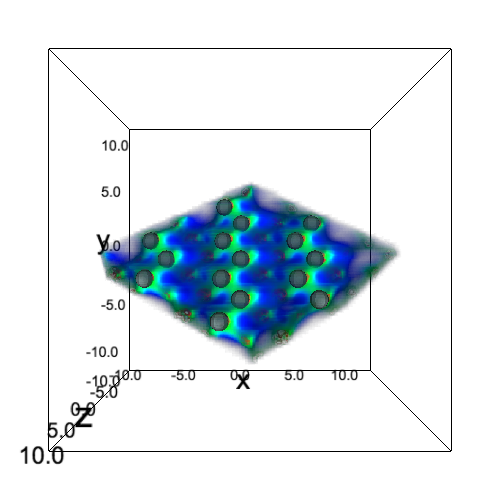

In [48]:
display(image3,metadata={'ipub':{'embed_html':{
    "filepath":'data/ivol_example3.html',
    "height":0.5}}})

# 2D Representations

Because the data is stored in a representation agnostic manner, this allows for the possibility of displaying the data in multiple ways. In particular, for publication quality images we may want to create a 2D representation of the scene.

In [56]:
struct = my_data.cif_files.FeS_mackinawite_cif.structure
vstructs = struct_to_visual(struct,'mackinawite')
geomanip = GeometryManipulation()
geomanip.align(vstructs,'c')
geomanip.repeat_cell(vstructs,'a',2)
geomanip.recentre(vstructs)
edict.pprint(vstructs,depth=2,no_values=True)

mackinawite_Fe: 
  cell_vectors: {...}
  centre:       
  color:        
  coords:       
  label:        
  radius:       
  transparency: 
  type:         
  visible:      
mackinawite_S: 
  cell_vectors: {...}
  centre:       
  color:        
  coords:       
  label:        
  radius:       
  transparency: 
  type:         
  visible:      


dict_keys(['mackinawite_Fe', 'mackinawite_S'])

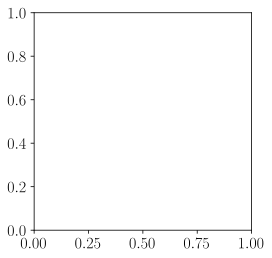

In [61]:
structs = vstructs
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
types = edict.filter_keys(structs,['type'])
skeys = edict.filter_values(types,['scatter']).keys()


In [58]:

def plot_atoms_top(structs,color_depth=None,
               axis_range=None,
               ax=None, legend=None,
               show_legend=True):
    """plot atoms and bounding boxes as top-down orthographic image,
    with atoms color lightened with decreasing z coordinate
    
    Parameters
    ----------
    structs : dict
    color_depth: float
        z-depth at which colors are completely lightened 
    zrotation : float
        rotate about z-axis
    axis_range : tuple
        (xmin,xmax,ymin,ymax)
               
    """
    if ax is None:
        fig = plt.figure()
        # initialize axis, important: set the aspect ratio to equal
        ax = fig.add_subplot(111, aspect='equal')

    legend = {} if legend is None else legend
    default_axis_range = None
        
    # filter df for atoms
    atoms_df = df1.loc[~df1['radius'].isnull()]
    if 'visible' in atoms_df:
        atoms_df = atoms_df[(atoms_df.visible)]

    if atoms_df.shape[0] != 0:
            
        # 'fade' the atom colors based on there z value
        x,y,z = np.asarray(pjs.atom.utils.rotate_vectors(
                    np.array(
                    atoms_df.position.values.tolist()),[0,0,1],zrotation).tolist()).T
        
        if color_depth is not None:
            clip = (z.max()-color_depth,z.max())
        else:
            clip = (z.min(),z.max())
            
        if default_axis_range is None:
            default_axis_range = [x.min(),x.max(),y.min(),y.max()]
        else:
            xmin,xmax,ymin,ymax = default_axis_range
            default_axis_range = [min(xmin,x.min()),max(xmax,x.max()),
                                  min(ymin,y.min()),max(ymax,y.max())]
        sort_mask = z.argsort() # to reverse [::-1]
        z_clipped = np.clip(z,clip[0],clip[1])
        if z_clipped.max() == z_clipped.min():
            z_norm = np.ones_like(z_clipped)
        else:
            z_norm=(z_clipped-clip[0])/(clip[1]-clip[0])

        lbound, ubound = 0.1, 1.
        z_scaled = (z_norm * (ubound - lbound)) + lbound
        zcolor = np.array([pjs.utils.lighter_color(c,1-f) for c,f in zip(atoms_df.color.values, z_scaled)])

        # create 2d atoms
        label_color = {}
        for (i, row),zcolor in zip(atoms_df.iloc[sort_mask].iterrows(),zcolor[sort_mask]):
            x,y,z = row.position
            ax.add_artist(mpl.patches.Circle(xy=(x, y),radius=row.radius,
                                             alpha=row.transparency,color=zcolor))
            if row.label in label_color:
                if label_color[row.label] != row.color:
                    raise ValueError('key creation: at least two atoms with the same label have different colors: {}'.format(row.label))
            label_color[row.label] = row.color    

        for label,color in label_color.items():
            Artist = plt.Line2D((0,1),(0,0), color=color, marker='o', linestyle='')
            if label in legend:
                raise ValueError('attempting to set muliple legend keys for label: {}'.format(label))
            legend[label] = Artist
        
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    if show_legend:
        # Put a legend to the right of the current axis
        labels = sorted(legend.keys())
        handles = [legend[k] for k in labels]
        ax.legend(handles,labels,loc='center left', bbox_to_anchor=(1, 0.5));

    if axis_range is not None:
        xmin,xmax,ymin,ymax = axis_range
        ax.set_xbound(xmin,xmax)
        ax.set_ybound(ymin,ymax)
    else:
        xmin,xmax,ymin,ymax = default_axis_range
        ax.set_xbound(xmin,xmax)
        ax.set_ybound(ymin,ymax)


    return ax, legend                   

# Analysis Distribution

# TODO

- Finalise electronic density section
    - transfer parsing code into jsonextended plugin
    - tidy rest of code and put into document
- Orthographic camera. Not yet implemented in ipyvolume, see [this issue](https://github.com/maartenbreddels/ipyvolume/issues/31) for current status.
- better control of spheres
    - radius rather than size
    - more segments
    - transparency level
- show lattice bounding box: parallelepiped wire frames 
- show nearest-neighbour coordination: polygons with vertices at nearest-neighbour positions (as shown in \cref{fig:nnpolygons})

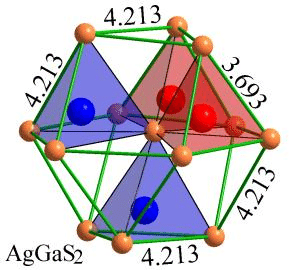

In [49]:
display(Image('data/nn_coordination.jpg',width=200),
        metadata={"ipub":{
      "figure":{
         "caption":"an example of nearest-neighbour polygons",
         "label":"fig:nnpolygons",
         "height":0.2}}})

- functional (browser side) controls, e.g. slider to translate/rotate point set. Not yet implemented in ipywidgets, see [this issue](https://github.com/jupyter-widgets/ipywidgets/issues/1109) for current status.
- volumes:
    - RuntimeWarning: invalid value encountered in true_divide 
    (serialize.py:43) presumably for (0,0,0) gradients
    - rarely get artifact rendering
    - isosurface rendering
    - multiple volumes
    - volumes with arbitrary centres
    - rotating volumes
- fullscreen
    - fails to open if multiple views instantiated
    - if volume is present,
    then the rendering becomes very low resolution
    and the volume disappears completely on exit